# Numpy 1D-DFT
- 電子の運動エネルギー，静電ポテンシャル，交換作用(LDA)を考慮した調和振動子の1次元DFT
- 下のハミルトニアンについて，波動方程式の解をself-consistentに解くことを目指す
$$\hat{H}=-\frac{1}{2}\frac{d^2}{dx^2}+v(x)\\
v(x)=v_{Ha}(x)+v_{LDA}(x)+x^2$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style("white")

# 微分作用素
- 微分項を行列で表現したい
- 例えば下のsinについて，微分作用素を適用してみる

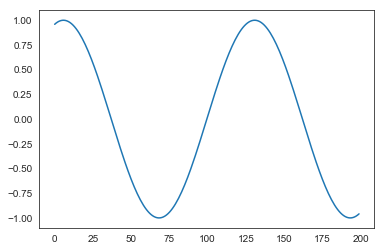

In [3]:
n_grid=200
x=np.linspace(-5,5,n_grid)
y=np.sin(x)
plt.plot(y)

### 1階
$$(\frac{dy}{dx})_{i}=\frac{y_{i+1}-{y_{i}}}{h}$$
と近似するなら
$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$
とすれば
$$(\frac{dy}{dx})_{i}=D_{ij} y_{j}$$
と書ける．（ただし端は定義できない)

($\delta_{ij}$はクロネッカーのデルタで，第3式はアインシュタイン縮約を用いている)

In [4]:
h=x[1]-x[0]
D=-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1)
D = D / h

### 2階

上と同じようにして
$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$

これは1階微分演算子を用いて下のように書ける(転置に注意)
$$D^2_{ij}=-D_{ik}D_{jk}$$

ただし端を処理する必要がある

In [5]:
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]

### 確認

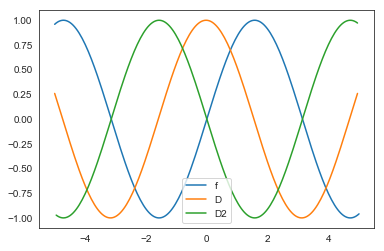

In [6]:
plt.plot(x,y, label="f")
plt.plot(x[:-1],D.dot(y)[:-1], label="D")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label="D2")
plt.legend()

# 相互作用のない電子について
- 以下のハミルトニアンは，与えられたグリッドサイズの箱に入った，相互作用のない自由粒子のものとなる
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2}$$

- シュレディンガー方程式の解とエネルギーは下のように1行で求まる

In [7]:
eig_non, psi_non=np.linalg.eigh(-D2/2)

プロット (ラベルはエネルギー)

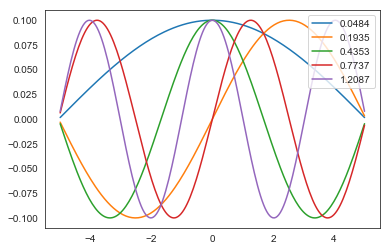

In [8]:
for i in range(5):
    plt.plot(x,psi_non[:,i], label=f"{eig_non[i]:.4f}")
    plt.legend(loc=1)

# 調和振動子
- 調和振動子のポテンシャル項$v_{ext}=x^2$を導入する:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2} + x^2$$

$v_{ext}(x)$の行列表現を$X$とする

In [9]:
X=np.diagflat(x*x)

- 解は前と同じようにして

In [10]:
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)

- プロット
    - ポテンシャルの影響で中心に寄っている

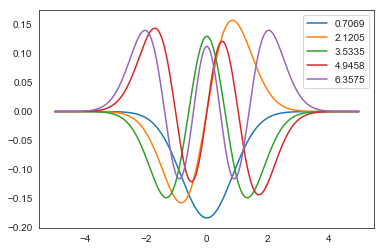

In [11]:
for i in range(5):
    plt.plot(x,psi_harm[:,i], label=f"{eig_harm[i]:.4f}")
    plt.legend(loc=1)

# 井戸型
- よくある井戸型ポテンシャル

In [12]:
w=np.full_like(x,1e10)
w[np.logical_and(x>-2,x<2)]=0.
eig_well, psi_well= np.linalg.eigh(-D2/2+np.diagflat(w))

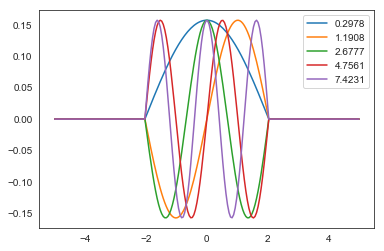

In [13]:
for i in range(5):
    plt.plot(x,psi_well[:,i], label=f"{eig_well[i]:.4f}")
    plt.legend(loc=1)

# 電子密度
- クーロン，ハートリー相互作用やLDAを入れたいが，これらはdensity functional
- なのでまずはdensityを考える
- このとき，波動関数の規格化条件を考える必要がある:
$$\int \lvert \psi \rvert ^2 dx = 1$$

- occupation numbersを$f_n$とおけば，density $n(x)$は:
$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

- 電子は各状態につき2つまで入ることができる (up, down spin) -> fn=0,1,2 for each n

In [14]:
# integral
def integral(x,y,axis=0):
    dx=x[1]-x[0]
    return np.sum(y*dx, axis=axis)

- 電子数

In [15]:
num_electron=17

- density

In [16]:
def get_nx(num_electron, psi, x):
    # 規格化
    I=integral(x,psi**2,axis=0)
    normed_psi=psi/np.sqrt(I)[None, :]
    
    # occupation num
    fn=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        fn.append(1)

    # density
    res=np.zeros_like(normed_psi[:,0])
    for ne, psi  in zip(fn,normed_psi.T):
        res += ne*(psi**2)
    return res

- plot
    - ポテンシャルの影響がよく分かる

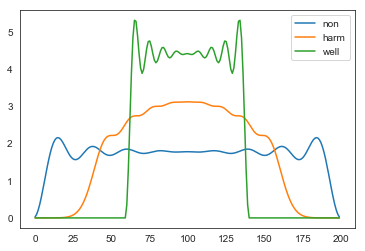

In [17]:
plt.plot(get_nx(num_electron,psi_non, x), label="non")
plt.plot(get_nx(num_electron,psi_harm, x), label="harm")
plt.plot(get_nx(num_electron,psi_well, x), label="well")
plt.legend(loc=1)

# Exchange energy
- 交換相互作用について考える (電子相関は面倒なので今回はパス)
- local density approximation (LDA) を用いると，以下のような汎関数となる:

$$ E_X^{LDA}[n] = -\frac{3}{4} \left(\frac{3}{\pi}\right)^{1/3} \int n^{4/3} dx$$

- potentialはこれをnによって微分することで求まる:

$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

- code

In [18]:
def get_exchange(nx,x):
    energy=-3./4.*(3./np.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

# coulomb potential
- Hatree energy
- 1次元の場合，3次元の表式をそのまま用いると発散してしまうので，以下のように定義する
$$ E_{Ha}=\frac{1}{2}\iint \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon}}dxdx'$$

    - ただし$\varepsilon$は正の適当に小さい定数

- ポテンシャルはnで微分して:
$$ v_{Ha}=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon}}dx'$$

- 行列形式で書くならば:
$$E_{Ha} = \frac{1}{2} \frac{n_in_jh^2}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$
$$v_{Ha, i} = \frac{n_jh}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$

In [19]:
def get_hatree(nx,x, eps=1e-1):
    h=x[1]-x[0]
    energy=np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential=np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return energy, potential

# KS方程式を解く：Self-consistency loop
0. densityを適当に初期化
1. 交換項，クーロン項を求める
2. ハミルトニアンを求める
3. 波動関数と固有値を求める
4. 収束判定を満たしていない場合，densityを計算して2. へ

In [20]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

In [21]:
max_iter=1000
energy_tolerance=1e-8
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

In [22]:
nx=np.zeros(n_grid)
for i in range(max_iter):
    ex_energy, ex_potential=get_exchange(nx,x)
    ha_energy, ha_potential=get_hatree(nx,x)
    
    # Hamiltonian
    H=-D2/2+np.diagflat(ex_potential+ha_potential+x*x)
    
    energy, psi= np.linalg.eigh(H)
    
    # log
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    
    # convergence
    if abs(energy_diff) < energy_tolerance:
        print("converged!")
        break
    
    # update density
    nx=get_nx(num_electron,psi,x)
else:
    print("not converged")

step: 0     energy: 0.7069     energy_diff: -inf
step: 1     energy: 16.3625    energy_diff: 15.6555321919
step: 2     energy: 13.8021    energy_diff: -2.5603559494
step: 3     energy: 15.3002    energy_diff: 1.4980525863
step: 4     energy: 14.4119    energy_diff: -0.8882287680
step: 5     energy: 14.9470    energy_diff: 0.5350438262
step: 6     energy: 14.6242    energy_diff: -0.3228271880
step: 7     energy: 14.8201    energy_diff: 0.1959328656
step: 8     energy: 14.7011    energy_diff: -0.1190355457
step: 9     energy: 14.7735    energy_diff: 0.0724651058
step: 10    energy: 14.7294    energy_diff: -0.0441312736
step: 11    energy: 14.7563    energy_diff: 0.0268946713
step: 12    energy: 14.7399    energy_diff: -0.0163922405
step: 13    energy: 14.7499    energy_diff: 0.0099933983
step: 14    energy: 14.7438    energy_diff: -0.0060926001
step: 15    energy: 14.7475    energy_diff: 0.0037147279
step: 16    energy: 14.7452    energy_diff: -0.0022649307
step: 17    energy: 14.7466   

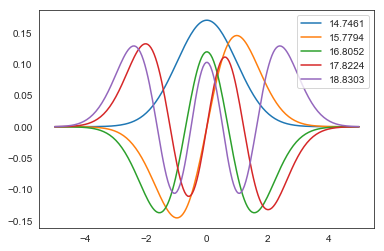

In [23]:
for i in range(5):
    plt.plot(x,psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)

- 相互作用項なしと比べるとどうか

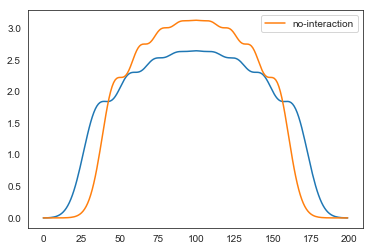

In [24]:
plt.plot(nx)
plt.plot(get_nx(num_electron,psi_harm,x), label="no-interaction")
plt.legend()

ちょっと反発しているのがわかる

# 以上